# Cartpole



The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    x & \dot{x} & \theta & \dot{\theta}
    \end{bmatrix}
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    F_{x}
    \end{bmatrix}
\end{equation*}
$$

The goal is to swing the carptole upright:
$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    0 & 0 & \pi & 0
    \end{bmatrix}
\end{equation*}
$$

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [3]:
import matplotlib.pyplot as plt

In [4]:
import pddp
import pddp.examples

In [5]:
import torch
import numpy as np

In [6]:
DT = 0.1  # Time step (s).
RENDER = True  # Whether to render the environment or not.
N = 25 # Horizon length.

# Disable uncertainty since we are dealing with known dynamics.
ENCODING = pddp.StateEncoding.IGNORE_UNCERTAINTY

In [7]:
cost = pddp.examples.cartpole.CartpoleCost()
model = pddp.examples.cartpole.CartpoleDynamicsModel(DT)
env = pddp.examples.cartpole.CartpoleEnv(dt=DT, render=RENDER)

In [8]:
def plot(Z, U):
    t = np.arange(N + 1) * DT
    X = pddp.utils.encoding.decode_mean(Z, ENCODING).detach().numpy()
    U = U.detach().numpy()

    x = X[:, 0]
    x_dot = X[:, 1]
    theta = np.unwrap(X[:, 2])  # Makes for smoother plots.
    theta_dot = X[:, 3]
    
    plt.figure()
    plt.plot(theta, theta_dot)
    plt.xlabel("Orientation (rad)")
    plt.ylabel("Angular velocity (rad/s)")
    plt.title("Orientation Phase Plot")

    plt.figure()
    plt.plot(t, x)
    plt.xlabel("Time (s)")
    plt.ylabel("Position (m)")
    plt.title("Position path")
    
    plt.figure()
    plt.plot(t, x_dot)
    plt.xlabel("Time (s)")
    plt.ylabel("Velocity (m / s)")
    plt.title("Velocity path")
    
    plt.figure()
    plt.plot(t, theta)
    plt.xlabel("Time (s)")
    plt.ylabel("Orientation (rad)")
    plt.title("Orientation path")

    plt.figure()
    plt.plot(t, theta_dot)
    plt.xlabel("Time (s)")
    plt.ylabel("Angular velocity (rad / s)")
    plt.title("Angular velocity path")
    
    plt.figure()
    plt.plot(t[:-1], U)
    plt.xlabel("Time (s)")
    plt.ylabel("Force (N)")
    plt.title("Action path")
    
    plt.figure()
    plt.plot(J_hist)
    plt.xlabel("Iteration")
    plt.ylabel("Total loss")
    plt.title("Loss path")

In [9]:
def on_iteration(iteration, Z, U, J_opt, accepted, converged):
    J_opt = J_opt.detach().numpy()

    J_hist.append(J_opt)
    info = "CONVERGED" if converged else ("accepted" if accepted else "FAILED")
    final_state = Z[-1].detach().numpy()
    final_state[2] = (final_state[2] + np.pi) % (2 * np.pi) - np.pi
    print("iteration", iteration + 1, info, J_opt, final_state)

In [10]:
controller = pddp.controllers.PDDPController(env, model, cost)

In [11]:
U = 1e-1 * torch.randn(N, model.action_size)

In [12]:
J_hist = []
controller.eval()
Z, U = controller.fit(U, encoding=ENCODING, n_iterations=200, tol=0,
                      on_iteration=on_iteration, u_min=torch.tensor([-2.0]), u_max=torch.tensor([2.0]))


iteration 1 accepted 51.625343 [ 0.20632382 -0.38910815  2.1620815  -5.4201064 ]
iteration 2 accepted 42.88775 [ 0.25333005 -0.28357974  2.3200445  -4.6225023 ]
iteration 3 accepted 40.99333 [ 0.2817179  -0.19277394  2.3492053  -4.421139  ]
iteration 4 accepted 40.09037 [ 0.27620044 -0.18106931  2.3621564  -4.329588  ]
iteration 5 accepted 39.103516 [ 0.2691924 -0.1692095  2.3770878 -4.2283134]
iteration 6 accepted 37.53112 [ 0.2499832  -0.06694821  2.3860993  -4.0913954 ]
iteration 7 accepted 33.628258 [ 2.2854882e-01 -3.3953963e-03  2.4594841e+00 -3.6194587e+00]
iteration 8 accepted 30.45927 [ 0.20242937  0.04298171  2.525195   -3.180471  ]
iteration 9 accepted 28.03986 [ 0.1712991   0.07645087  2.5801144  -2.798137  ]
iteration 10 accepted 19.918562 [-0.15063947  0.2269652   3.014005    0.46368682]
iteration 11 accepted 19.649227 [-0.11250601  0.28033954  2.9977086   0.35263497]
iteration 12 accepted 19.59648 [-0.07469144  0.35882884  2.9847383   0.25582635]
iteration 13 accepted 19

iteration 103 FAILED 13.608256 [-0.00597828 -0.05920645  3.137127    0.00929475]



/Users/anass/Dev/personal/pddp/pddp/controllers/ilqr.py:241: UserWarning: exceeded max regularization term
  warnings.warn("exceeded max regularization term")


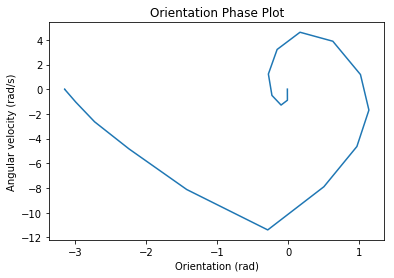

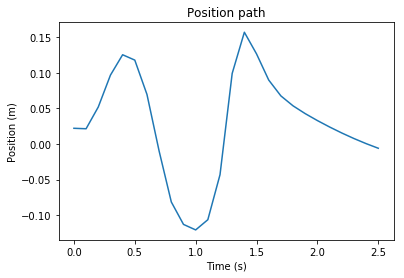

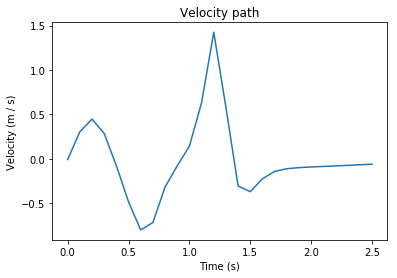

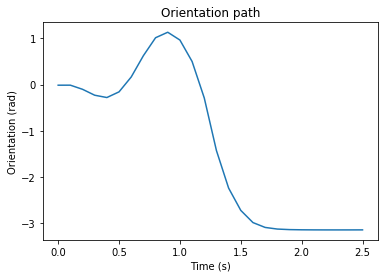

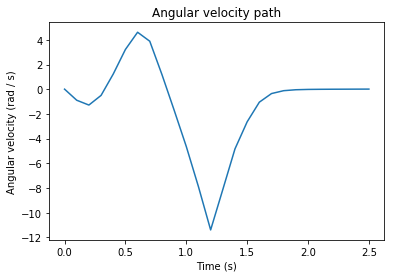

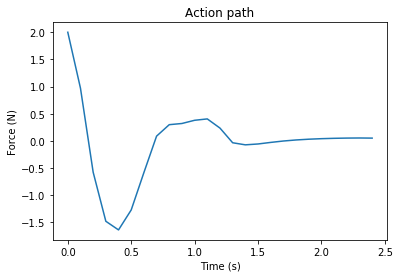

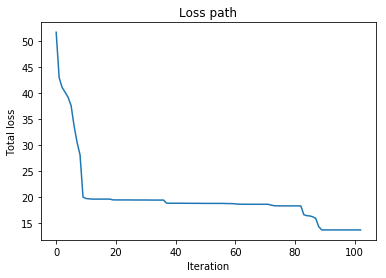

In [13]:
plot(Z, U)

In [14]:
if RENDER:
    # Wait for user interaction before visualizing. 
    _ = input("Press ENTER to continue")

Press ENTER to continue


In [15]:
env.reset()
for i in range(N):
    z = env.get_state().encode(ENCODING)
    u = controller(z, i, ENCODING)
    env.apply(u)

In [16]:
env.close()